# Técnica da camada equivalente aplicada ao processamento e inversão de dados magnéticos

Este código utiliza a biblioteca de modelagem e inversão de dados geofísicos denominada [Fatiando a Terra](http://www.fatiando.org/index.html) para exemplificar a aplicação da técnica da camada equivalente (Dampney, 1969; Emilia, 1973; Silva, 1986; Leão e Silva, 1989; Li e Oldenburg, 2010; Barnes e Lumley, 2011; Oliveira Jr. et al., 2013; Li et al., 2014) ao processamento e interpretação de dados magnéticos.

* Dampney, C. N. G., 1969, The equivalent source technique: GEOPHYSICS, 34, 39-53. doi: [10.1190/1.1439996](http://dx.doi.org/10.1190/1.1439996)

* Emilia, D. A., 1973, Equivalent sources used as an analytic base for processing total magnetic field profiles: GEOPHYSICS, 38, 339-348. doi: [10.1190/1.1440344](http://dx.doi.org/10.1190/1.1440344)

* Silva, J. B. C., 1986, Reduction to the pole as an inverse problem and its application to low-latitude anomalies: GEOPHYSICS, 51, 369-382. doi: [10.1190/1.1442096](http://dx.doi.org/10.1190/1.1442096)

* Leão, J. W. D., e J. B. C. Silva, 1989, Discrete linear transformations of potential field data: GEOPHYSICS, 54, 497-507. doi: [10.1190/1.1442676](http://dx.doi.org/10.1190/1.1442676)

* Li, Y., e D. W. Oldenburg, 2010, Rapid construction of equivalent sources using wavelets: GEOPHYSICS, 75, L51-L59. doi: [10.1190/1.3378764](http://dx.doi.org/10.1190/1.3378764)

* Barnes, G., e J. Lumley, 2011, Processing gravity gradient data: GEOPHYSICS, 76, I33-I47. doi: [10.1190/1.3548548](http://dx.doi.org/10.1190/1.3548548)

* Oliveira Jr., V. C., V. C. F. Barbosa, e L. Uieda, 2013, Polynomial equivalent layer: GEOPHYSICS, 78, G1-G13. doi: [10.1190/geo2012-0196.1](http://dx.doi.org/10.1190/geo2012-0196.1)

* Li, Y., M. Nabighian, e D. W. Oldenburg, 2014, Using an equivalent source with positivity for low-latitude reduction to the pole without striation: GEOPHYSICS, 79, J81-J90. doi: [10.1190/geo2014-0134.1](http://dx.doi.org/10.1190/geo2014-0134.1)

In [1]:
%matplotlib inline
import numpy as np
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere, prism
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion.regularization import Damping, LCurve
from fatiando.vis import mpl

### Pontos onde são calculados os dados

In [2]:
shape = (60, 60) # número de dados ao longo de x e y
N = shape[0]*shape[1] # número de dados
area = [-3000, 3000, -3000, 3000] # x mínimo, x máximo, y mínimo e y máximo da área
xp, yp, zp = gridder.regular(area, shape, z=-100) # grade regular localizada em z = -100 m

xc = 0.5*(area[1] + area[0])
yc = 0.5*(area[3] + area[2])

dx, dy = gridder.spacing(area, shape)

In [3]:
print dx
print dy

101.694915254
101.694915254


### Campo geomagnético local

In [4]:
inc = -30. # graus
dec = 40. # graus

### Corpos sintéticos

In [5]:
incs = inc
decs = dec
amps = 3.

model = [mesher.Prism(-500., 500., -500., 500., 10., 1010., \
                      {'magnetization': utils.ang2vec(amps, incs, decs)})]

In [6]:
# Projeção horizontal dos corpos
projecao = []
for i, p in enumerate(model):
    projecao.append(p.get_bounds()[:4])

### Anomalia de campo total (em nT)

In [7]:
act_aprox = prism.tf(xp, yp, zp, model, inc, dec)

### Plot dos dados

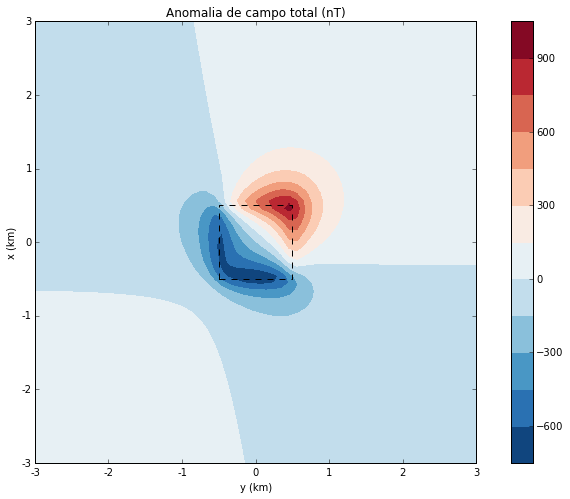

In [8]:
mpl.close('all')
mpl.figure(figsize=(10,7))

mpl.title("Anomalia de campo total (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Construção de uma camada equivalente

In [9]:
#h = 3.*0.5*(dx+dy)
h = np.max(zp) + 200.
camada = mesher.PointGrid(area, h, shape)

In [10]:
ajuste = EQLTotalField(xp, yp, zp, act_aprox, inc, dec, camada, incs, decs)

In [11]:
f0 = np.trace(ajuste.hessian(None))/ajuste.nparams

In [12]:
regularizacao = Damping(camada.size)

In [13]:
inversao = LCurve(ajuste, regularizacao, [f0*(10.**i) for i in range(-15, -1)]).fit()

In [14]:
camada.addprop('magnetization', utils.ang2vec(inversao.estimate_, incs, decs))

In [15]:
act_pre = inversao.predicted()

### Ajuste

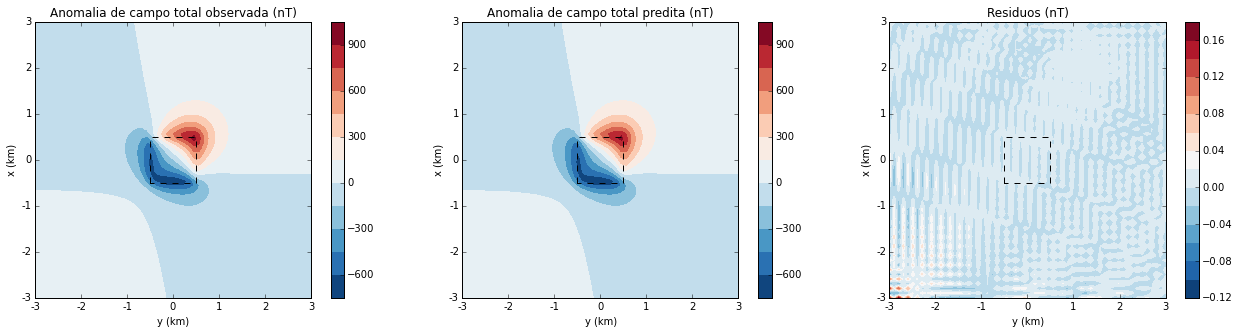

In [16]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total observada (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total predita (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_pre, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_pre - act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Continuação para cima

In [17]:
dado_cont_verdadeiro = prism.tf(xp, yp, zp - 300., model, inc, dec)

In [18]:
dado_cont_calculado = sphere.tf(xp, yp, zp - 300., camada, inc, dec)

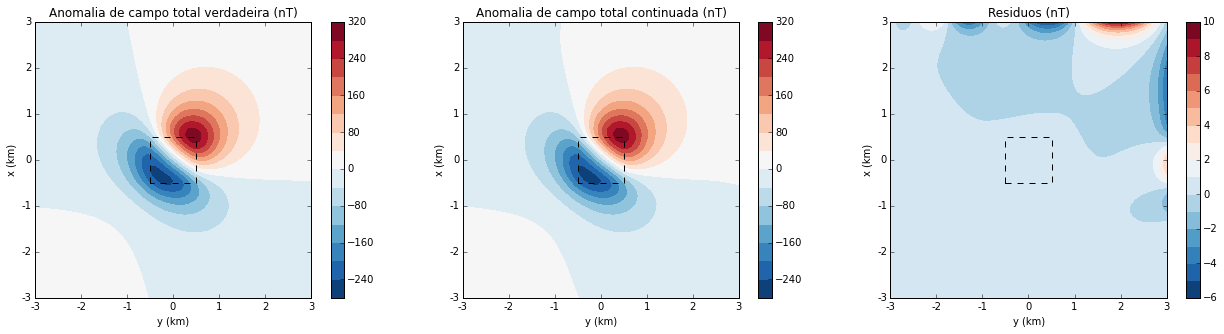

In [19]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total verdadeira (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total continuada (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_calculado - dado_cont_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Cálculo de derivadas

In [20]:
delta = 10.

In [21]:
dx_verdadeira = (prism.tf(xp + delta, yp, zp, model, inc, dec) - \
                 prism.tf(xp - delta, yp, zp, model, inc, dec))/ \
                 (2.*delta)
dy_verdadeira = (prism.tf(xp, yp + delta, zp, model, inc, dec) - \
                 prism.tf(xp, yp - delta, zp, model, inc, dec))/ \
                 (2.*delta)
dz_verdadeira = (prism.tf(xp, yp, zp + delta, model, inc, dec) - \
                 prism.tf(xp, yp, zp - delta, model, inc, dec))/ \
                 (2.*delta)

In [22]:
dx_calculada = (sphere.tf(xp + delta, yp, zp, camada, inc, dec) - \
                sphere.tf(xp - delta, yp, zp, camada, inc, dec))/ \
               (2.*delta)
dy_calculada = (sphere.tf(xp, yp + delta, zp, camada, inc, dec) - \
                sphere.tf(xp, yp - delta, zp, camada, inc, dec))/ \
               (2.*delta)
dz_calculada = (sphere.tf(xp, yp, zp + delta, camada, inc, dec) - \
                sphere.tf(xp, yp, zp - delta, camada, inc, dec))/ \
               (2.*delta)

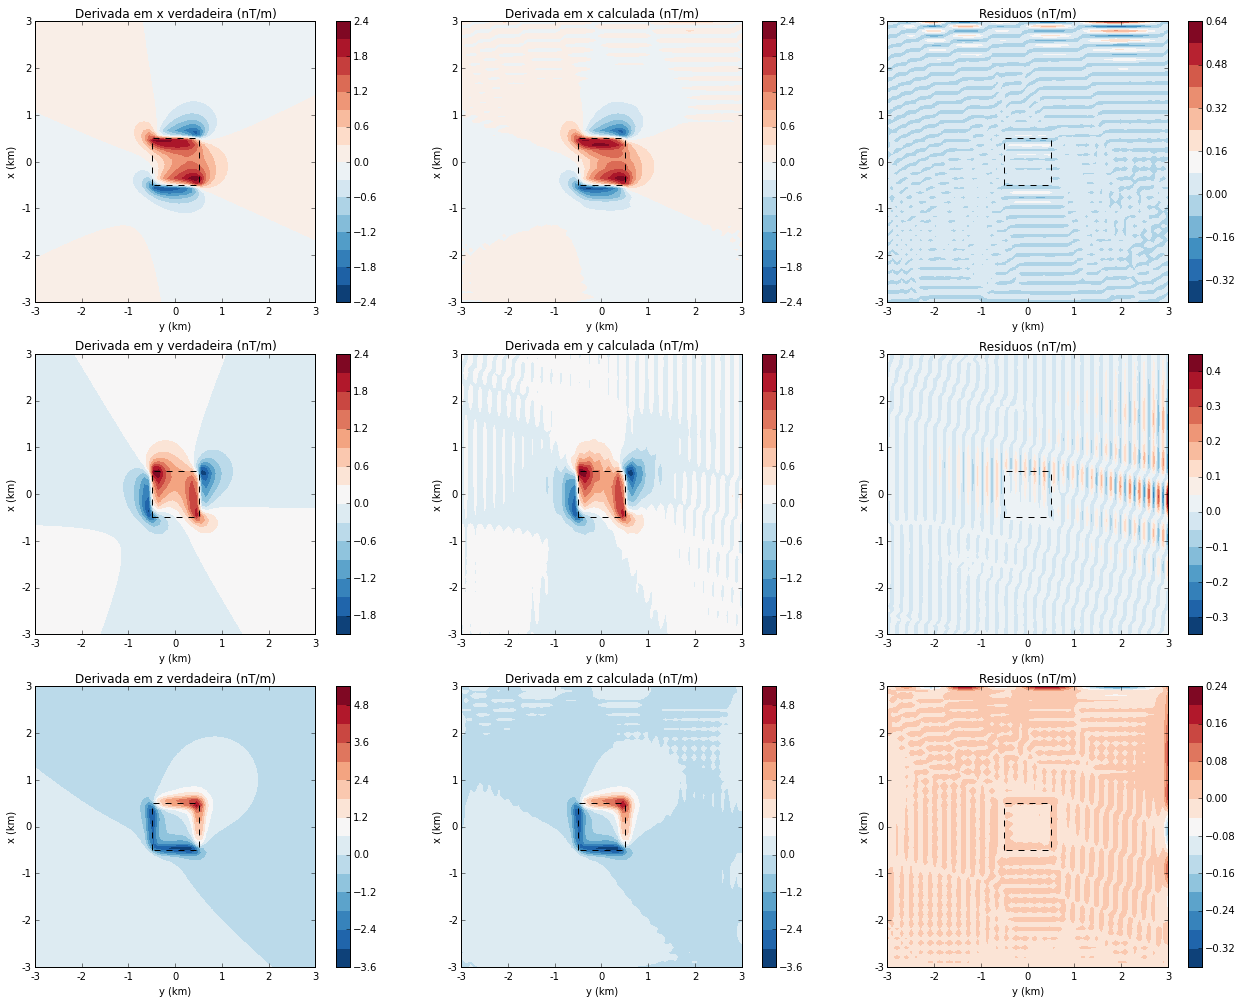

In [23]:
mpl.close('all')
mpl.figure(figsize=(18,14))

mpl.subplot(3,3,1)
mpl.title("Derivada em x verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,2)
mpl.title("Derivada em x calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,3)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada - dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,4)
mpl.title("Derivada em y verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,5)
mpl.title("Derivada em y calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,6)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada - dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,7)
mpl.title("Derivada em z verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,8)
mpl.title("Derivada em z calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,9)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada - dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Redução ao polo

In [24]:
model_polo = [mesher.Prism(-500., 500., -500., 500., 10., 1010., \
                          {'magnetization': utils.ang2vec(amps, 90., 0.)})]

In [25]:
dado_polo_verdadeiro = prism.tf(xp, yp, zp, model_polo, 90., 0.)

In [26]:
camada_polo = mesher.PointGrid(area, h, shape)

In [27]:
camada_polo.addprop('magnetization', utils.ang2vec(inversao.estimate_, 90., 0.))

In [28]:
dado_polo_calculado = sphere.tf(xp, yp, zp, camada_polo, 90., 0.)

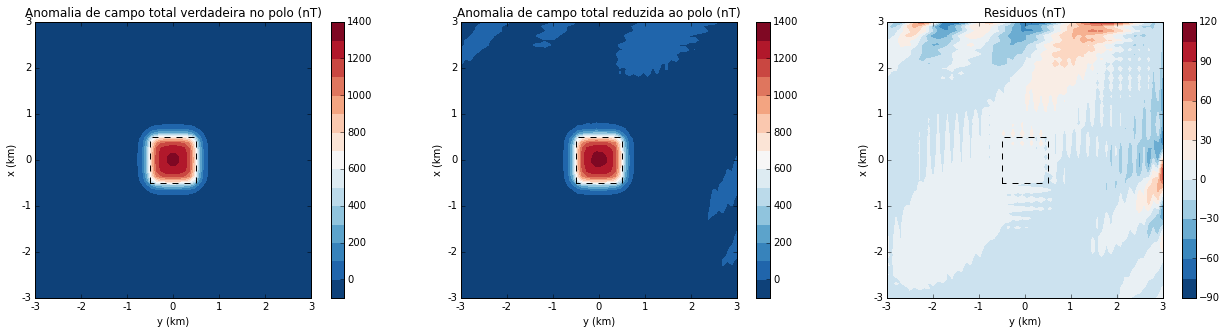

In [29]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total verdadeira no polo (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total reduzida ao polo (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_calculado - dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Gradiente total

In [30]:
grad_total_verdadeiro = np.sqrt(dx_verdadeira**2 + dy_verdadeira**2 + dz_verdadeira**2)

In [31]:
grad_total_calculado = np.sqrt(dx_calculada**2 + dy_calculada**2 + dz_calculada**2)

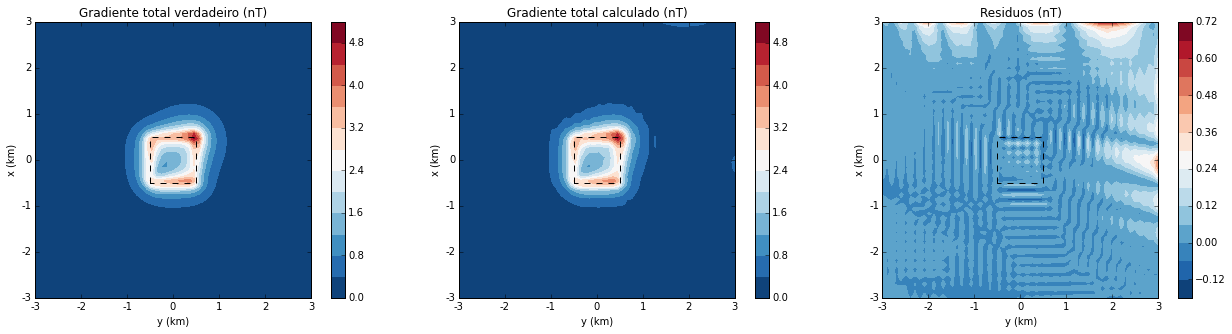

In [32]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Gradiente total verdadeiro (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Gradiente total calculado (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_calculado - grad_total_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()